In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import csv
import math
from scipy import optimize
from scipy import stats

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)

gyro = 1.6e-19/9.1e-31 #Gyromagnetic magnetic ratio (C/kg)

def Lorentzian(H, S, A, Delta, H0, V): 
    return ((S*Delta**2)+(A*(H-H0)*Delta))/(Delta**2+(H-H0)**2)+V
def damping(f, alpha, delta0):
    return 2*np.pi*(f*1e9)*alpha*10000/gyro+delta0
def Kittel(H0, demag):
    return gyro/(2*np.pi)*(np.sqrt(H0*(H0+demag)))*1e-13
def data_slicing(sliced_array,slicing_ind):
    n = np.sum(slicing_ind)
    np.append(sliced_array,0)
    output = []
    if len(sliced_array) == n:
        cnt = 0
        for i in range(len(slicing_ind)):
            i_start=cnt
            cnt+=slicing_ind[i]
            i_stop=cnt
            output.append(sliced_array[i_start:i_stop])
    return output
def Angdep(p, Yd, Xd, Zf, a):
    p=p/180*np.pi
    a=a/180*np.pi
    return Yd*np.cos(p+a)*np.sin(2*(p+a))+Xd*np.sin(p+a)*np.sin(2*(p+a))+Zf*np.sin(2*(p+a))

# Frequency dependence with $x_{2}$
The $x_{2}$ is the magnetic field calibrated by Lakeshore, which is saved with directory:  

/Users/didierjim/Documents/SCREAM/Measurement/ST-FMR field calibration/220406/

In [10]:
io = r'/Users/didierjim/Documents/SCREAM/_Measurement/2022-10-gmw+stfmr/original w4'
Sample_name = '_'
files = sorted(glob.glob(os.path.join(io,'*'+Sample_name+'*')), key = lambda path:float(path.split('_')[-3]))

In [11]:
fs = []
for i in range(len(files)):
    fs.append(float(files[i].split('_')[-3]))
print(fs)

file_count = []
freq = []
cnt = 1
for j in range(1,len(files)):
    if fs[j] == fs[j-1]:
        cnt += 1
    else:
        file_count.append(cnt)
        freq.append(fs[j-1])
        cnt = 1
    if j == len(files)-1:
        file_count.append(cnt)
        freq.append(fs[j])
print(np.sum(file_count), file_count)
print(freq)
file_times = []
for i in range(len(files)):
    a=files[i].split('/')[-1].split('_')[-1].split('.')[0][-5:]
    file_times.append(a)

# Find zero_ind
import_files = pd.read_csv(files[0])
result = import_files.values
zero_ind = int(np.where(result[:,0]== -300)[0])
print('zero field index = ',zero_ind)

# Find measured field
f_range = int(result[0,0])
f_step = int(result[0,0]-result[1,0])

gaussscan = f'/Users/didierjim/Documents/SCREAM/_Measurement/ST-FMR field calibration/220406/\
step{f_step}/{f_range}FIX.csv'
x2 = np.loadtxt(gaussscan,delimiter=',',skiprows=1,usecols=(0,2,))
print(np.shape(x2[:,:]))

[8.0, 9.0, 10.0, 11.0, 12.0]
5 [1, 1, 1, 1, 1]
[8.0, 9.0, 10.0, 11.0, 12.0]
zero field index =  215
(401, 2)


<Figure size 1080x720 with 0 Axes>

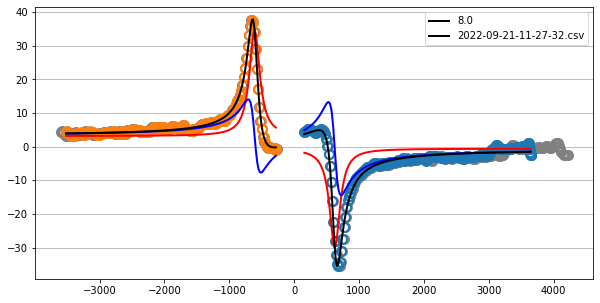

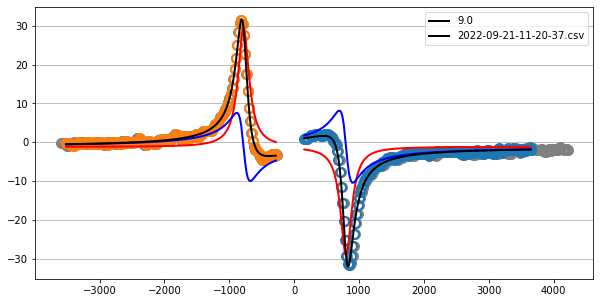

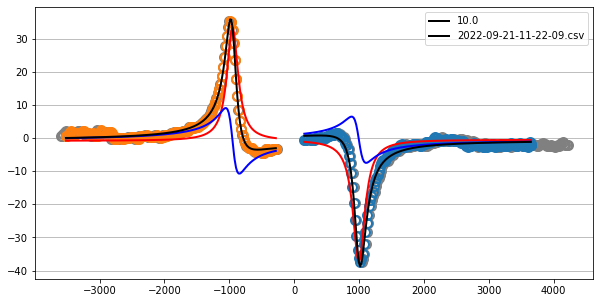

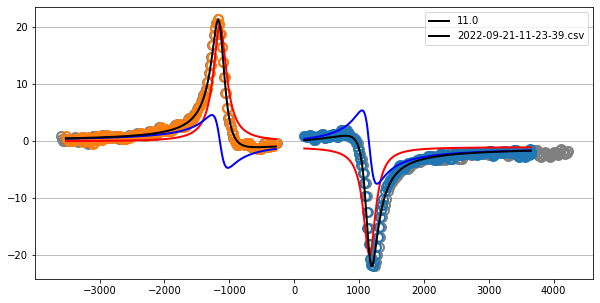

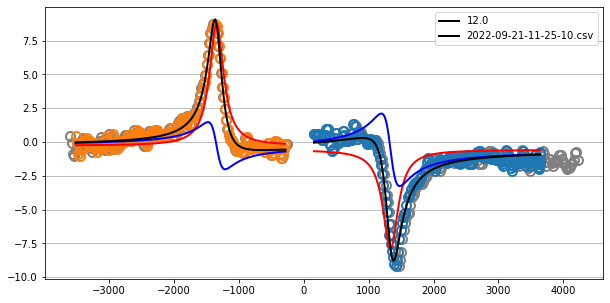

In [12]:

para_p = np.zeros((len(files), 6))
para_n = np.zeros((len(files), 6))
std_err_p = []
std_err_n = []

curves_p = []
curves_n = []

fit_range = [0.01, 0.52, 0.57, 0.99]
plt.figure(figsize = (15,10))
for i in range(len(files)):
    import_files = pd.read_csv(files[i])
    result = import_files.values
    results = pd.read_csv(files[i])
    length = len(results.values[:,0])

    H_p0 = results.values[int(length*fit_range[0]):int(length*fit_range[1]),0]+300
    H_p = x2[int(length*fit_range[0]):int(length*fit_range[1]),1]*-1-125
    Vmix_p = results.values[int(length*fit_range[0]):int(length*fit_range[1]),1]
    
    try:
        para_L, cov_L = optimize.curve_fit(Lorentzian,H_p,Vmix_p, [0.0, 0.0, 280, 700, 280])
    except RuntimeError:
        print('Runtime Error (+):', files[i].split('/')[-1].split('_')[-1])
    if para_L[2] < 0:
        para_L[1],para_L[2] = para_L[1]*-1,para_L[2]*-1
    
    plt.figure(figsize = (10,5))
    plt.grid(axis = 'y')
    plt.plot(H_p0,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9, color = 'gray')
    plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    
    plt.plot(H_p, Lorentzian(H_p,para_L[0],0,para_L[2],para_L[3],para_L[4]),color = 'red', linewidth = 2)
    plt.plot(H_p, Lorentzian(H_p,0,para_L[1],para_L[2],para_L[3],para_L[4]),color = 'blue', linewidth = 2)
    plt.plot(H_p, Lorentzian(H_p,para_L[0],para_L[1],para_L[2],para_L[3],para_L[4]), label = fs[i],color = 'black', linewidth = 2)
    para_p[i,0] = fs[i]
    para_p[i,1:] = para_L
    std_err_p.append(np.sqrt(np.diag(cov_L)))
    

    H_n0 = results.values[int(length*fit_range[2]):int(length*fit_range[3]),0]+300
    H_n = x2[int(length*fit_range[2]):int(length*fit_range[3]),1]*-1-125
    Vmix_n = results.values[int(length*fit_range[2]):int(length*fit_range[3]),1]

    try:
        para_L, cov_L = optimize.curve_fit(Lorentzian,H_n,Vmix_n, [0.0, 0.0, -280, -700, 280])
    except RuntimeError:
        print('Runtime Error (-):', files[i].split('/')[-1].split('_')[-1])
    
    if para_L[2] < 0:
        para_L[1],para_L[2] = para_L[1]*-1,para_L[2]*-1
    plt.plot(H_n0,Vmix_n,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9, color = 'gray')
    plt.plot(H_n,Vmix_n,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    
    plt.plot(H_n, Lorentzian(H_n,para_L[0],0,para_L[2],para_L[3],para_L[4]),color = 'red', linewidth = 2)
    plt.plot(H_n, Lorentzian(H_n,0,para_L[1],para_L[2],para_L[3],para_L[4]),color = 'blue', linewidth = 2)
    plt.plot(H_n, Lorentzian(H_n,para_L[0],para_L[1],para_L[2],para_L[3],para_L[4]), label = files[i].split('/')[-1].split('_')[-1],color = 'black', linewidth = 2)
    para_n[i,0] = fs[i]
    para_n[i,1:] = para_L
    std_err_n.append(np.sqrt(np.diag(cov_L)))
    
    if i==0:
        curves_p.append(x2[:zero_ind,1]*-1-125)
        curves_n.append(x2[zero_ind:,1]*-1-125)
    
    curves_p.append(results.values[:zero_ind,1]-para_p[i,-1])
    curves_n.append(results.values[zero_ind:,1]-para_n[i,-1])
    

    plt.legend()
#print(np.array(std_err_p))
#print(np.array(std_err_n))

In [13]:
para_n[:,2] = para_n[:,2]*-1
para_n[:,4] = para_n[:,4]*-1

t = ['fix', 'S', 'A', 'Delta', 'H0', 'V0', 'S/A']
para_pn = np.zeros((len(files)*2,7))
for i in range(len(files)):
    para_pn[2*i,:-1] = para_p[i,:]
    para_pn[2*i+1,:-1] = para_n[i,:]
    
para_pn[:,-1] = para_pn[:,1]/para_pn[:,2]
#print(para_pn)

tt = ['fix', 'S', 'S_err', 'A', 'A_err', 'Delta', 'Delta_err', 'H0', 'H0_err', 'V0','V0_err', 'S/A','S/A_err']
para_pn_avg = np.zeros((len(freq),13))
para_p_avg = np.zeros((len(freq),13))
para_n_avg = np.zeros((len(freq),13))
para_pn_avg[:,0] = freq
para_p_avg[:,0] = freq
para_n_avg[:,0] = freq
#print('f',freq)
for i in range(6):
    para_slice = data_slicing(para_pn[:,i+1],np.array(file_count)*2)
    if i != 5:
        p_slice = data_slicing(para_p[:,i+1],file_count)
        n_slice = data_slicing(para_n[:,i+1],file_count)
    else:
        p_slice = data_slicing(para_p[:,1]/para_p[:,2],file_count)
        n_slice = data_slicing(para_n[:,1]/para_n[:,2],file_count)
        
    for k in range(len(file_count)):
        para_pn_avg[k,2*i+1] = np.mean(para_slice[k])
        para_pn_avg[k,2*i+2] = np.std(para_slice[k])
        para_p_avg[k,2*i+1] = np.mean(p_slice[k])
        para_p_avg[k,2*i+2] = np.std(p_slice[k])
        para_n_avg[k,2*i+1] = np.mean(n_slice[k])
        para_n_avg[k,2*i+2] = np.std(n_slice[k])

    #print(tt[2*i+1], np.around(para_p_avg[:,2*i+1],2),'\t',np.around(para_n_avg[:,2*i+1],2))
    #print(tt[2*i+2], np.around(para_p_avg[:,2*i+2],2),'\t',np.around(para_n_avg[:,2*i+2],2))

pd.DataFrame(np.around(np.vstack((para_p_avg,para_n_avg)),2), columns=tt)

,fix,S,S_err,A,A_err,Delta,Delta_err,H0,H0_err,V0,V0_err,S/A,S/A_err
0,8.0,-29.45,0.0,-27.76,0.0,97.14,0.0,625.07,0.0,-0.61,0.0,1.06,0.0
1,9.0,-28.17,0.0,-18.61,0.0,103.34,0.0,799.27,0.0,-1.16,0.0,1.51,0.0
2,10.0,-36.95,0.0,-13.96,0.0,111.42,0.0,996.90,0.0,-0.53,0.0,2.65,0.0
3,11.0,-19.02,0.0,-12.91,0.0,114.43,0.0,1160.58,0.0,-1.10,0.0,1.47,0.0
4,12.0,-7.34,0.0,-5.37,0.0,141.04,0.0,1336.41,0.0,-0.58,0.0,1.37,0.0
5,8.0,31.53,0.0,21.80,0.0,96.43,0.0,610.89,0.0,3.16,0.0,1.45,0.0
6,9.0,30.65,0.0,17.60,0.0,103.28,0.0,781.02,0.0,-1.22,0.0,1.74,0.0
7,10.0,34.25,0.0,19.83,0.0,104.16,0.0,950.94,0.0,-0.86,0.0,1.73,0.0
8,11.0,20.39,0.0,9.30,0.0,123.09,0.0,1145.37,0.0,-0.10,0.0,2.19,0.0
9,12.0,9.03,0.0,3.49,0.0,131.98,0.0,1345.61,0.0,-0.27,0.0,2.58,0.0


No handles with labels found to put in legend.


[1.06069565 1.51331129 2.64604369 1.47326858 1.36635782] 
 [1.44660572 1.74171072 1.72742888 2.19309682 2.58452021]


,27-32,20-37,22-09,23-39,25-10
freq,8.00,9.00,10.00,11.00,12.00
S/Ap,1.06,1.51,2.65,1.47,1.37
S/An,1.45,1.74,1.73,2.19,2.58


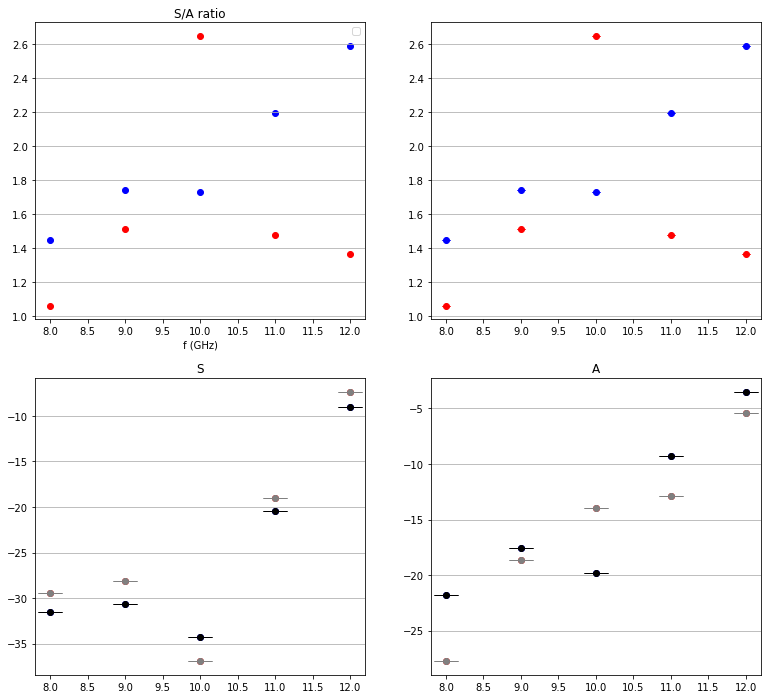

In [14]:
#SA ratio
plt.figure(figsize = (13,12))
plt.subplot(221)
plt.scatter(fs,para_n[:,1]/para_n[:,2], color='b')
plt.scatter(fs,para_p[:,1]/para_p[:,2], color='r')
plt.grid(axis = 'y')
#plt.ylim((-20,50))


plt.title('S/A ratio')
plt.xlabel('f (GHz)')
plt.legend()


#error bar by multiple measurements

plt.subplot(222)
plt.grid(axis = 'y')
plt.errorbar(freq,para_n_avg[:,11], yerr=para_n_avg[:,12], fmt='o',ecolor='b',color='b',elinewidth=2,capsize=4)
plt.errorbar(freq,para_p_avg[:,11], yerr=para_p_avg[:,12], fmt='o',ecolor='r',color='r',elinewidth=2,capsize=4)
print(para_p_avg[:,11],'\n',para_n_avg[:,11])

plt.subplot(223)
plt.title('S')
plt.errorbar(freq,-para_n_avg[:,1], yerr=para_n_avg[:,2], fmt='o',ecolor='k',color='k',elinewidth=2,capsize=12)
plt.errorbar(freq,para_p_avg[:,1], yerr=para_p_avg[:,2], fmt='o',ecolor='grey',color='grey',elinewidth=2,capsize=12)
plt.scatter(fs,-para_n[:,1], color='b')
plt.scatter(fs,para_p[:,1], color='r')
plt.grid(axis = 'y')

plt.subplot(224)
plt.title('A')
plt.errorbar(freq,-para_n_avg[:,3], yerr=para_n_avg[:,4], fmt='o',ecolor='k',color='k',elinewidth=2,capsize=12)
plt.errorbar(freq,para_p_avg[:,3], yerr=para_p_avg[:,4], fmt='o',ecolor='grey',color='grey',elinewidth=2,capsize=12)
plt.scatter(fs,-para_n[:,2], color='b')
plt.scatter(fs,para_p[:,2], color='r')
plt.grid(axis = 'y')

pd.DataFrame(np.array([para_p[:,0],np.round(para_p[:,1]/para_p[:,2],2),np.round(para_n[:,1]/para_n[:,2],2)]),\
             columns = file_times, index=['freq','S/Ap','S/An'])

p= 0.0277 +- 0.006 
n= 0.0254 +- 0.004
intercept
p= 14.584 +- 23.072 
n= 20.86 +- 16.014


,27-32,20-37,22-09,23-39,25-10
freq,8.00,9.00,10.00,11.00,12.00
Dp,97.14,103.34,111.42,114.43,141.04
Dn,96.43,103.28,104.16,123.09,131.98


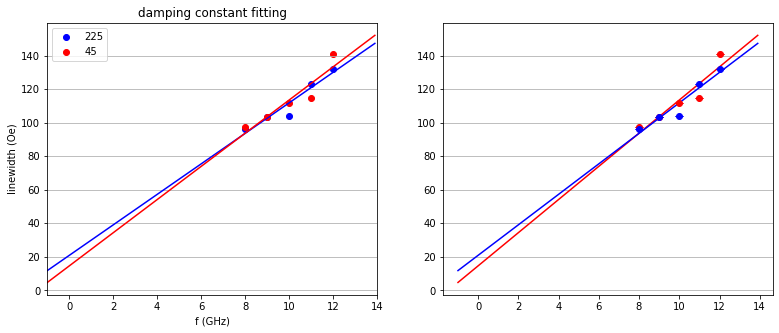

In [15]:
#Linewidth & damping constant
plt.figure(figsize = (13,5))

#plt.ylim(100,160)

x = np.arange(-1,np.max(freq)+2,0.1)
#Rp, Covp = np.polyfit(fs, abs(para_p[:,3]),1,cov=True)
Rp,Covp = optimize.curve_fit(damping, fs, para_p[:,3], [0.01,10])
Rn,Covn = optimize.curve_fit(damping, fs, para_n[:,3], [0.01,10])
print('p=',np.around(Rp[0],4),'+-',np.around(np.sqrt(np.diag(Covp))[0],3),
      '\nn=',np.around(Rn[0],4),'+-',np.around(np.sqrt(np.diag(Covn))[0],3))

print('intercept\np=',np.around(Rp[1],3),'+-',np.around(np.sqrt(np.diag(Covp))[1],3),
      '\nn=',np.around(Rn[1],3),'+-',np.around(np.sqrt(np.diag(Covn))[1],3))
plt.subplot(121)
#plt.errorbar(fs, abs(para_p[:,3]),yerr = std_err_p, fmt='o',ecolor='r',color='r',elinewidth=2,capsize=4)
#plt.errorbar(fs, abs(para_n[:,3]),yerr = std_err_n, fmt='o',ecolor='b',color='b',elinewidth=2,capsize=4)

plt.scatter(fs, para_n[:,3],color='b',label='225')
plt.scatter(fs, para_p[:,3],color='r',label='45')

plt.xlim(-1,np.max(freq)+2)

plt.plot(x,damping(x,Rn[0],Rn[1]),color='b')
plt.plot(x,damping(x,Rp[0],Rp[1]),color='r')
plt.grid(axis = 'y')

plt.title('damping constant fitting')
plt.xlabel('f (GHz)')
plt.ylabel('linewidth (Oe)')
plt.legend()


#error bar by multiple measurements
Z1,covz1 = optimize.curve_fit(damping, freq, abs(para_p_avg[:,5]), [0.01,10])
Z2,covz2 = optimize.curve_fit(damping, freq, abs(para_n_avg[:,5]), [0.01,10])

plt.subplot(122)
plt.plot(x,damping(x,Z1[0],Z1[1]),color='r')
plt.plot(x,damping(x,Z2[0],Z2[1]),color='b')
plt.grid(axis = 'y')
        
plt.errorbar(freq,para_p_avg[:,5],yerr=para_p_avg[:,6], fmt='o',ecolor='r',color='r',elinewidth=2,capsize=4,label='45')
plt.errorbar(freq,para_n_avg[:,5],yerr=para_p_avg[:,6], fmt='o',ecolor='b',color='b',elinewidth=2,capsize=4,label='225')

pd.DataFrame(np.array([para_p[:,0],para_p[:,3].round(2),para_n[:,3].round(2)]),\
             columns = file_times, index=['freq','Dp','Dn'])

p= 12192.2522 +- 115.33 
n= 12439.0858 +- 71.111


<ErrorbarContainer object of 3 artists>

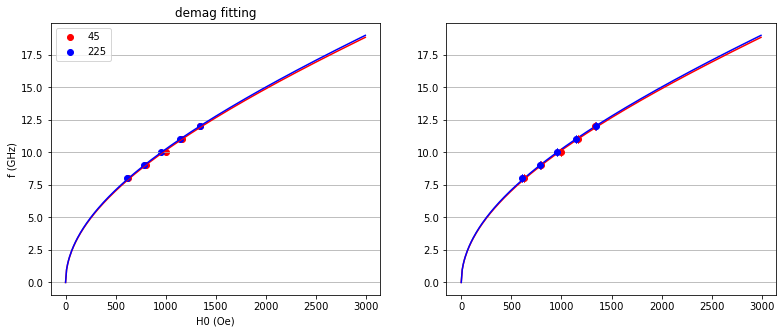

In [16]:
#H0 & demag
plt.figure(figsize = (13,5))

x = np.arange(0,3000,10)

Kp,covKp = optimize.curve_fit(Kittel, para_p[:,4], fs, [10000])
Kn,covKn = optimize.curve_fit(Kittel, para_n[:,4], fs, [10000])
print('p=',np.around(Kp[0],4),'+-',np.around(np.sqrt(np.diag(covKp))[0],3),
      '\nn=',np.around(Kn[0],4),'+-',np.around(np.sqrt(np.diag(covKn))[0],3))

plt.subplot(121)
plt.scatter(para_p[:,4],fs,color='r',label='45')
plt.scatter(para_n[:,4],fs,color='b',label='225')

plt.plot(x,Kittel(x,Kp[0]),color='r')
plt.plot(x,Kittel(x,Kn[0]),color='b')

plt.title('demag fitting')
plt.ylabel('f (GHz)')
plt.xlabel('H0 (Oe)')
plt.grid(axis = 'y')
plt.legend()

#error bar by multiple measurements  
KKp,covKKp = optimize.curve_fit(Kittel, para_p_avg[:,7], freq, [10000])
KKn,covKKn = optimize.curve_fit(Kittel, para_n_avg[:,7], freq, [10000])

plt.subplot(122)
plt.plot(x,Kittel(x,KKp[0]),color='r')
plt.plot(x,Kittel(x,KKn[0]),color='b')
plt.grid(axis = 'y')
        
plt.errorbar(para_p_avg[:,7],freq, xerr=para_p_avg[:,8], fmt='o',ecolor='r',color='r',elinewidth=2,capsize=4)
plt.errorbar(para_n_avg[:,7],freq, xerr=para_n_avg[:,8], fmt='o',ecolor='b',color='b',elinewidth=2,capsize=4)

No handles with labels found to put in legend.


[0.08782874 0.11156353 0.17599161 0.09137827 0.0794939 ] 
 [0.1222601  0.13103073 0.11852921 0.13810787 0.15126252]
0.10925120663764532 0.03499568332781728


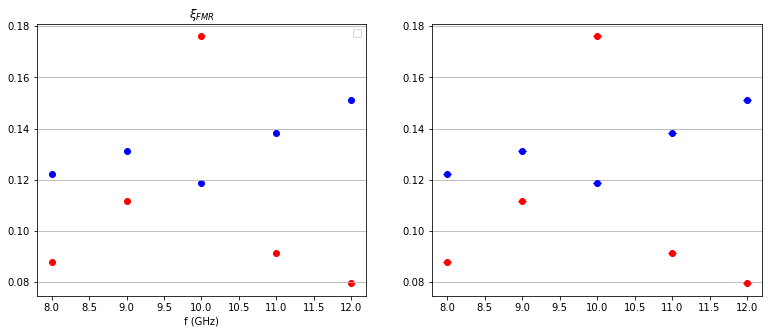

In [17]:
# FMR efficiency
# Device characteristics
tHM = 4e-9 # thickness of spin Hall material (meters) 
tFM = 3e-9 # thickness of magnetic layer - dead layer (meters)

tIN = 0e-9 # thickness of non-interacting layer (only for shunting) (meters)
rhoHM = 27.4 # muOhm-cm
rhoIN = 292.8

u0Ms = 1 # assume 1 Tesla
hbar = 1.05e-34 #Planck's constant/2pi (m2*kg/s)

def xiFMR(SAratio, H0, Hdemag):
    return SAratio*1.6e-19*u0Ms*tFM*(tHM+rhoHM/rhoIN*tIN)*np.sqrt(1+Hdemag/H0)/hbar

xi_n = xiFMR(para_n[:,1]/para_n[:,2], abs(para_n[:,4]), Kn[0])
xi_p = xiFMR(para_p[:,1]/para_p[:,2], abs(para_p[:,4]), Kp[0])
xi_n_slice = data_slicing(xi_n,file_count)
xi_p_slice = data_slicing(xi_p,file_count)
xi_n_avg = np.zeros((len(freq),2))
xi_p_avg = np.zeros((len(freq),2))
for k in range(len(file_count)):
    xi_n_avg[k,:] = [np.mean(xi_n_slice[k]),np.std(xi_n_slice[k])]
    xi_p_avg[k,:] = [np.mean(xi_p_slice[k]),np.std(xi_p_slice[k])]


plt.figure(figsize = (13,5))
plt.subplot(121)
             
plt.scatter(fs,xi_n, color='b')
plt.scatter(fs,xi_p, color='r')
plt.grid(axis = 'y')
#plt.ylim((-20,50))

plt.title('$\\xi_{FMR}$')
plt.xlabel('f (GHz)')
plt.legend()

#error bar by multiple measurements

plt.subplot(122)
plt.grid(axis = 'y')
plt.errorbar(freq,xi_n_avg[:,0], yerr=xi_n_avg[:,1], fmt='o',ecolor='b',color='b',elinewidth=2,capsize=4)
plt.errorbar(freq,xi_p_avg[:,0], yerr=xi_p_avg[:,1], fmt='o',ecolor='r',color='r',elinewidth=2,capsize=4)
print(xi_p_avg[:,0],'\n',xi_n_avg[:,0])
print(np.mean(xi_p_avg[:,0]),np.std(xi_p_avg[:,0]))


In [18]:
for i in range(len(curves_n)):
    if i != 0:
        if len(curves_n[i])-len(curves_n[i-1]) !=0:
            print('Length error!!')

print('Error checked')

Error checked


[0, 1, 2, 3, 4]
8.0
9.0
10.0
11.0
12.0
(6, 215) (6, 186) (5, 215) (5, 186)
(11, 215) (11, 186) (5, 215) (5, 186)
(401, 11)
Hext	8.0GHz	9.0GHz	10.0GHz	11.0GHz	12.0GHz	8.0S+A	9.0S+A	10.0S+A	11.0S+A	12.0S+A	


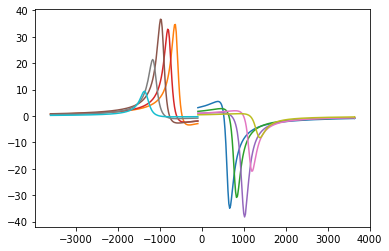

In [19]:
#Save files
directory = '/Users/didierjim/Documents/SCREAM/_Analysis/fitted/'
NAME = 'original W4CFB3'#remember to change thickness

#Curves
#contructing lists of fitting curves
ind_freq = []
ind=-1
Cur_p1,Cur_n1 = [curves_p[0]], [curves_n[0]]

Cur_p,Cur_n = [],[]
for i in range(len(freq)):
    ind+=file_count[i]
    ind_freq.append(int(ind))
print(ind_freq)
for i in ind_freq:
#for i in range(12):
    print(para_p[i,0])
    L_p = Lorentzian(np.array(curves_p[0]),para_p[i,1],para_p[i,2],para_p[i,3],para_p[i,4],0)
    L_n = Lorentzian(np.array(curves_n[0]),para_n[i,1],-para_n[i,2],para_n[i,3],-para_n[i,4],0)
    
    plt.plot(Cur_p1[0],L_p)
    plt.plot(Cur_n1[0],L_n)
    Cur_p1.append(curves_p[i+1])
    Cur_n1.append(curves_n[i+1])
    Cur_p.append(L_p)
    Cur_n.append(L_n)

print(np.shape(Cur_p1),np.shape(Cur_n1),np.shape(Cur_p),np.shape(Cur_n))
#curves = np.append(np.array(curves_p),np.array(curves_n),axis=1)
Cur_p1+=Cur_p
Cur_n1+=Cur_n
print(np.shape(Cur_p1),np.shape(Cur_n1),np.shape(Cur_p),np.shape(Cur_n))
curves = np.append(Cur_p1,Cur_n1,axis=1)
curves = np.transpose(curves)

print(np.shape(curves))
    
header = 'Hext\t'
for j in range(2):
    for i in freq:
        if j==0:
            header+=str(i)+'GHz\t'
        elif j==1:
            header+=str(i)+'S+A\t'
print(header)
np.savetxt(directory+'curves_'+NAME+'.tsv',curves,delimiter='\t',header=header)

In [20]:
#raw fitting
xi_pn = np.stack((xi_p,xi_n)).transpose().flatten()
B = np.stack((xi_pn,para_pn[:,4],para_pn[:,0]),axis=1)
BB = np.hstack((para_pn[:,:4],para_pn[:,5:],B))
print(np.shape(BB))
np.savetxt(directory+'rfit_'+NAME,BB,delimiter='\t',header='f\tS\tA\tDelta\tV0\tS/A\txi\tH0\tf')

#avg fitting
XI = np.vstack((xi_p_avg,xi_n_avg))
#A = np.vstack((para_pn_avg,para_p_avg,para_n_avg)) #original, but I think pn_avg is unnecessary 
A = np.vstack((para_p_avg,para_n_avg))
AA = np.hstack((A[:,:7],A[:,9:],XI,A[:,7:9]))

AAA = np.zeros((np.shape(AA)[0],np.shape(AA)[1]+1))
AAA[:,:-1] = AA
AAA[:,-1] = AA[:,0]
print(np.shape(AAA))
np.savetxt(directory+'avgfit_'+NAME,AAA,delimiter='\t',header='f\tS\tS_err\tA\tA_err\tDelta\tDelta_err\tV0\tV0_err\tS/A\tS/A_err\txi\txi_err\tH0\tH0_err\tf')

(10, 9)
(10, 16)


# Fix resonance field fitting



In [14]:
#Fix resonance field fitting
fix_H0 = 1500
pos = Hr

para_p = np.zeros((len(files), 6))
para_n = np.zeros((len(files), 6))
std_err_p = []
std_err_n = []
lowpts = 0
highpts = 0
curves_p = []
curves_n = []


plt.figure(figsize = (15,10))
for i in range(len(files)):
    import_files = pd.read_csv(files[i])
    result = import_files.values
    Datamax, Datamin = np.max(result[:,1]), np.min(result[:,1])
    #Hr = float(((result[result[:,1]==Datamax,0]+result[result[:,1]==Datamin,0])/2)[0])
    
    max_ind = int(np.where(result[:,1]==Datamax)[0][0])
    min_ind = int(np.where(result[:,1]==Datamin)[0][0])

    if max_ind > min_ind:
        p_ind, n_ind = min_ind, max_ind
    elif max_ind < min_ind:
        p_ind, n_ind = max_ind, min_ind
    
    lowpts = int(50*(fs[i]/fs[0]))
    highpts = int(50*(fs[i]/fs[0]))
    if p_ind-highpts < 0 or n_ind+highpts>=len(result[:,0]):
        highpts=p_ind-5
    
    if p_ind+lowpts > zero_ind or n_ind-lowpts<zero_ind:
        lowpts=-p_ind+zero_ind+20
        
    
    results = pd.read_csv(files[i])
    length = len(results.values[:,0])
    H_p = results.values[p_ind-highpts:p_ind+lowpts,0]-Hr
    Vmix_p = results.values[p_ind-highpts:p_ind+lowpts,1]
    
    #plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    
    para_L, cov_L = optimize.curve_fit(lambda x, S, A, Delta, V: Lorentzian(x, S, A, Delta, fix_H0, V),H_p,Vmix_p,[0.0, 0.0, 280, 20]) 
    if para_L[2] < 0:
        para_L[1],para_L[2] = para_L[1]*-1,para_L[2]*-1
    plt.figure(figsize = (10,5))
    plt.grid(axis = 'y')
    plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    plt.plot(H_p, Lorentzian(H_p,para_L[0],para_L[1],para_L[2],fix_H0,para_L[3]), label = fs[i],color = 'black', linewidth = 2)
    para_p[i,0] = fs[i]
    para_p[i,4] = fix_H0
    para_p[i,1:4] = para_L[0:-1]
    para_p[i,-1] = para_L[-1]
    std_err_p.append(np.sqrt(np.diag(cov_L))[2])
    
    H_n = results.values[n_ind-lowpts:n_ind+highpts,0]-Hr
    Vmix_n = results.values[n_ind-lowpts:n_ind+highpts,1]
    #plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    para_L, cov_L = optimize.curve_fit(lambda x, S, A, Delta, V: Lorentzian(x, S, A, Delta, -1*fix_H0, V),H_n,Vmix_n,[0.0, 0.0, -280, 20])
    if para_L[2] < 0:
        para_L[1],para_L[2] = para_L[1]*-1,para_L[2]*-1
    plt.plot(H_n,Vmix_n,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    plt.plot(H_n, Lorentzian(H_n,para_L[0],para_L[1],para_L[2],fix_H0*-1,para_L[3]), label = files[i].split('/')[-1].split('_')[-1],color = 'black', linewidth = 2)
    para_n[i,0] = fs[i]
    para_n[i,4] = fix_H0*-1
    para_n[i,1:4] = para_L[0:-1]
    para_n[i,-1] = para_L[-1]
    std_err_n.append(np.sqrt(np.diag(cov_L))[2])
    
    if i==0:
        curves_p.append(results.values[:zero_ind,0]-Hr)
        curves_n.append(results.values[zero_ind:,0]-Hr)
    
    curves_p.append(results.values[:zero_ind,1]-para_p[i,-1])
    curves_n.append(results.values[zero_ind:,1]-para_n[i,-1])
    

    plt.legend()

NameError: name 'Hr' is not defined

# Angle-dependent ST-FMR fitting

Here the freq is replaced by the nominal degree defined by substrate direction

In [1213]:
io = r'/Users/didierjim/Documents/SCREAM/Measurement/2022-04-Cr/Cr20/Co20 angdep/reverse/*deg'
Sample_name = '_'
files = sorted(glob.glob(os.path.join(io,'*'+Sample_name+'*')), key = lambda path:float(path.split('/')[-2].split('deg')[0]))
#print(files[1])

In [1214]:
fs = []
for i in range(len(files)):
    fs.append(float(files[i].split('/')[-2].split('deg')[0]))
#print(fs)

file_count = []
freq = [] # Here is degree (filename, defined by substrate but not H field)
cnt = 1
for j in range(1,len(files)):
    if fs[j] == fs[j-1]:
        cnt += 1
    else:
        file_count.append(cnt)
        freq.append(fs[j-1])
        cnt = 1
    if j == len(files)-1:
        file_count.append(cnt)
        freq.append(fs[j])
print(np.sum(file_count), file_count)
print(freq)
for i in range(len(files)):
    print(files[i].split('/')[-1].split('_')[-1])
    
# Find zero_ind
import_files = pd.read_csv(files[0])
result = import_files.values
zero_ind = int(np.where(result[:,0]== -300)[0])
print('zero field index = ',zero_ind)

# Find measured field
f_range = int(result[0,0])
f_step = int(result[0,0]-result[1,0])

gaussscan = f'/Users/didierjim/Documents/SCREAM/Measurement/ST-FMR field calibration/220406/\
step{f_step}/{f_range}FIX.csv'
x2 = np.loadtxt(gaussscan,delimiter=',',skiprows=1,usecols=(0,2,))
print(np.shape(x2[:,:]))

26 [2, 5, 5, 5, 5, 4]
[-15.0, 0.0, 15.0, 30.0, 45.0, 60.0]
2022-04-28-16-44-35.csv
2022-04-28-16-45-44.csv
2022-04-28-15-15-24.csv
2022-04-28-15-17-40.csv
2022-04-28-15-13-08.csv
2022-04-28-15-14-16.csv
2022-04-28-15-16-32.csv
2022-04-28-15-30-22.csv
2022-04-28-15-29-14.csv
2022-04-28-15-26-58.csv
2022-04-28-15-28-06.csv
2022-04-28-15-31-31.csv
2022-04-28-15-36-30.csv
2022-04-28-15-37-38.csv
2022-04-28-15-38-46.csv
2022-04-28-15-41-03.csv
2022-04-28-15-39-55.csv
2022-04-28-16-21-05.csv
2022-04-28-16-24-42.csv
2022-04-28-16-19-56.csv
2022-04-28-16-22-14.csv
2022-04-28-16-23-32.csv
2022-04-28-16-33-51.csv
2022-04-28-16-31-33.csv
2022-04-28-16-32-42.csv
2022-04-28-16-30-23.csv
zero field index =  165
(301, 2)


In [1215]:
# Find Hr
import_files = pd.read_csv(files[1])
result = import_files.values
Datamax, Datamin = np.max(result[:,1]), np.min(result[:,1])
Hr = float((result[result[:,1]==Datamax,0][0]+result[result[:,1]==Datamin,0][0])/2)
print('\nmax at',result[result[:,1]==Datamax,0][0],'Oe, min at',result[result[:,1]==Datamin,0][0], 'Oe, Hr =', Hr)
print(type(Hr))

max_ind = int(np.where(result[:,1]==Datamax)[0][0])
min_ind = int(np.where(result[:,1]==Datamin)[0][0])

if max_ind > min_ind:
    p_ind, n_ind = min_ind, max_ind
elif max_ind < min_ind:
    p_ind, n_ind = max_ind, min_ind
    
print(p_ind, n_ind)
zero_ind = int((p_ind+n_ind)/2)

#We fix values here
Hr=-300.0
zero_ind=165
#Hr=-300.0
#zero_ind=215


max at -840.0 Oe, min at 380.0 Oe, Hr = -230.0
<class 'float'>
131 192


RuntimeError (-) 60.0 2022-04-28-16-33-51.csv


<ipython-input-1216-b44a27d9bf3e>:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,5))


<Figure size 1080x720 with 0 Axes>

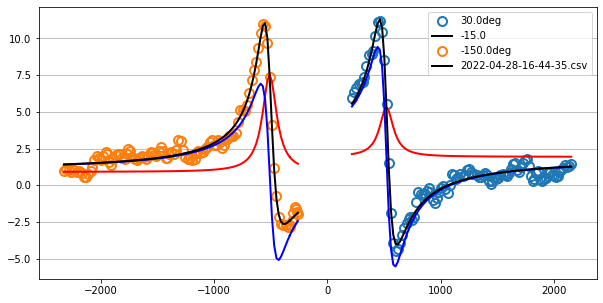

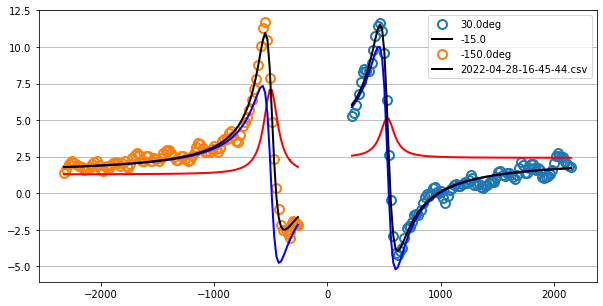

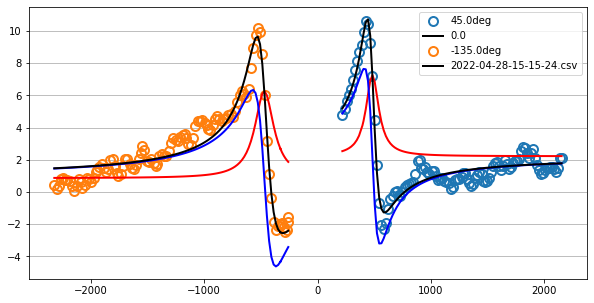

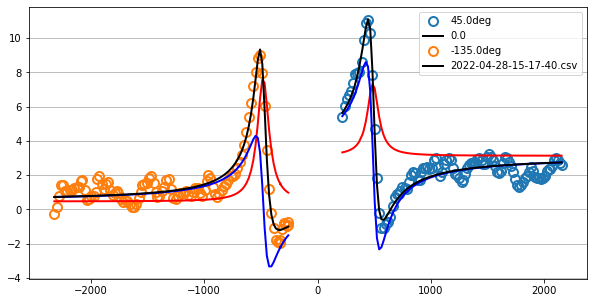

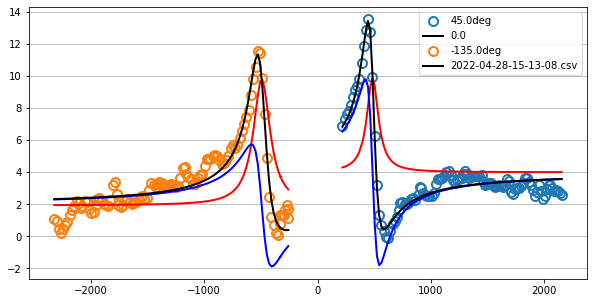

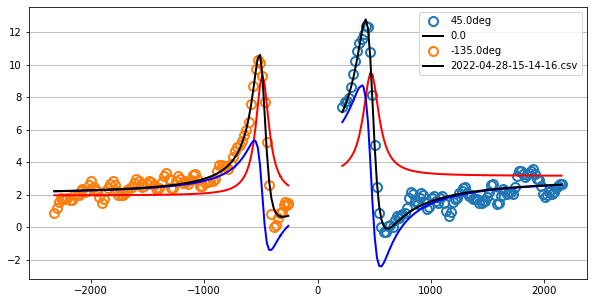

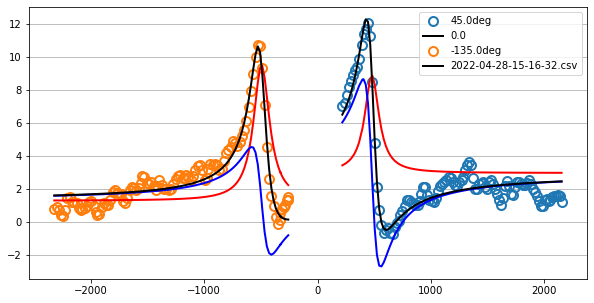

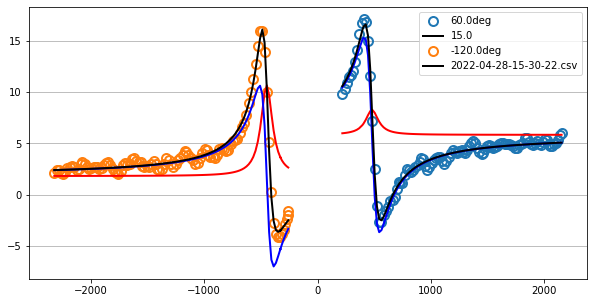

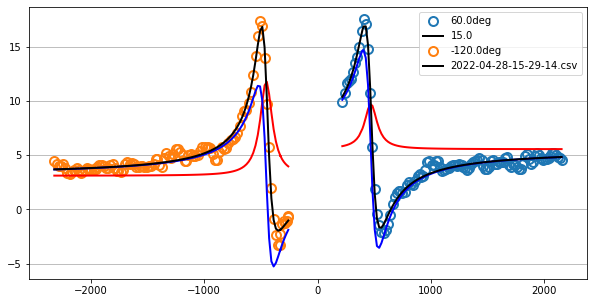

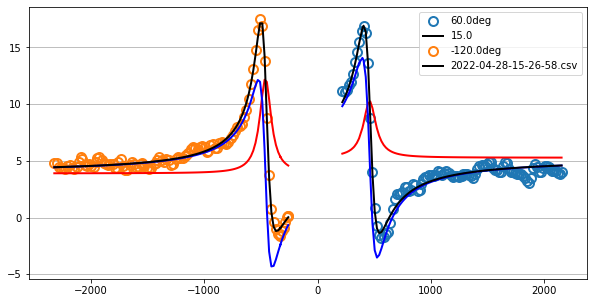

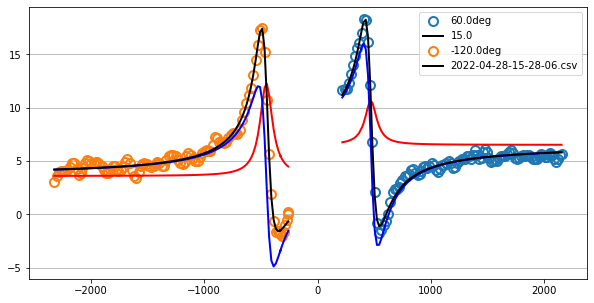

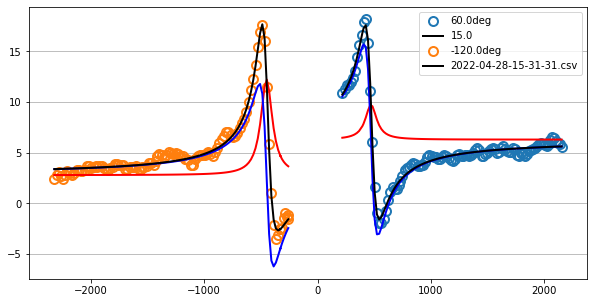

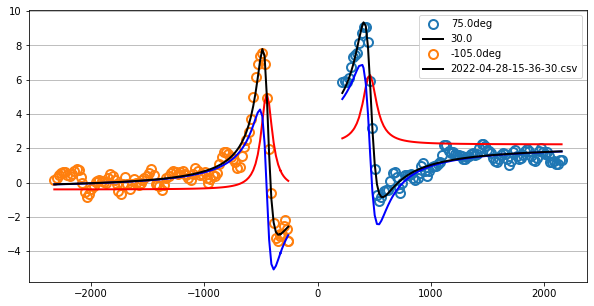

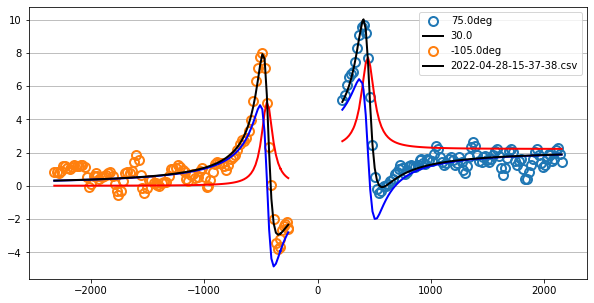

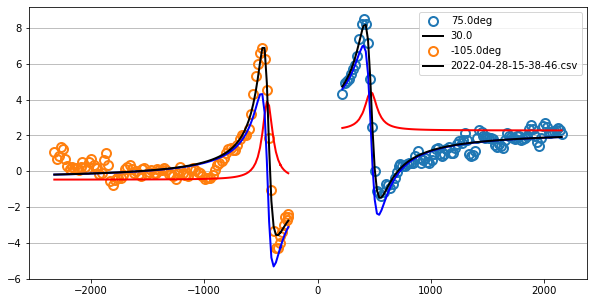

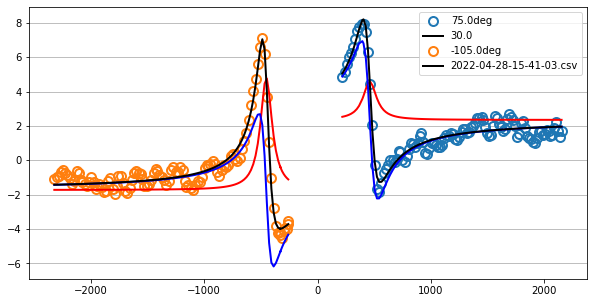

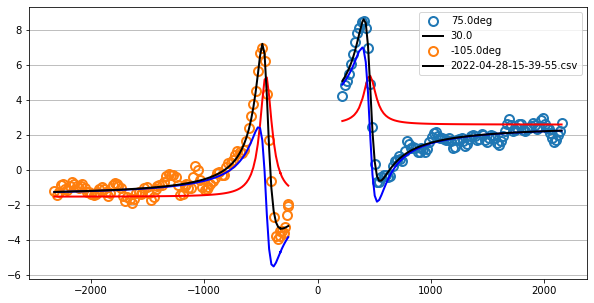

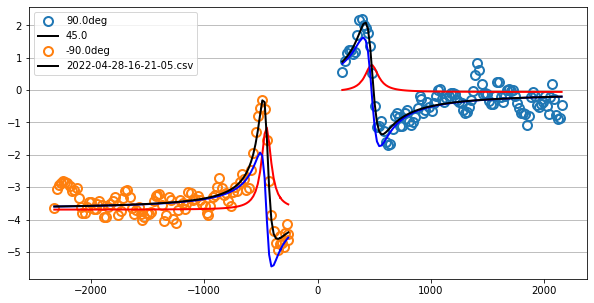

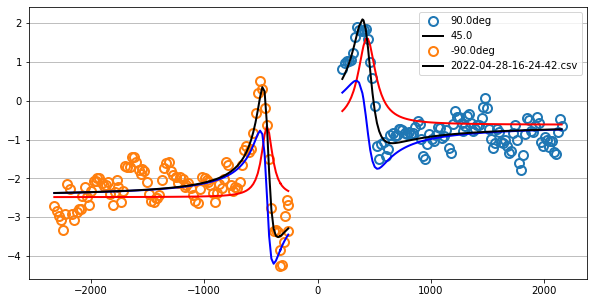

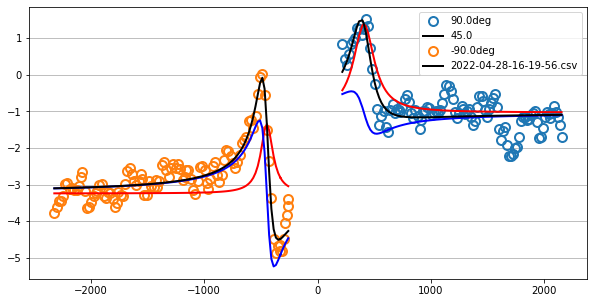

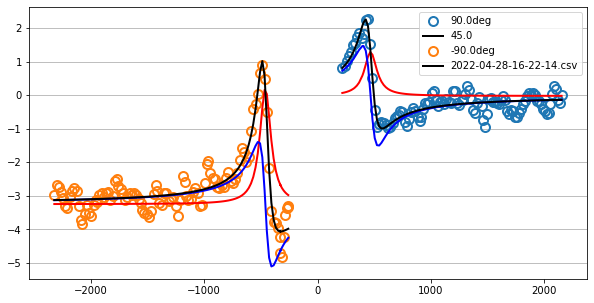

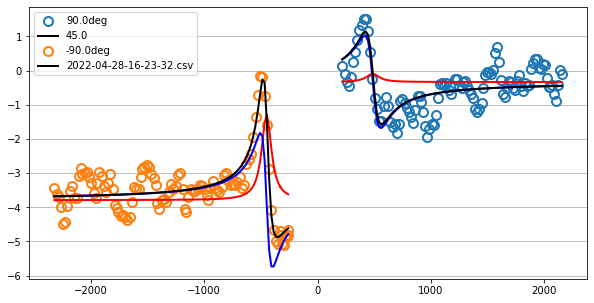

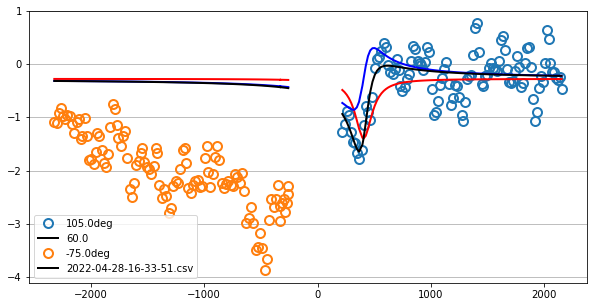

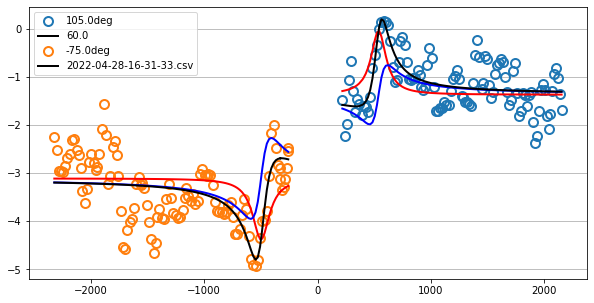

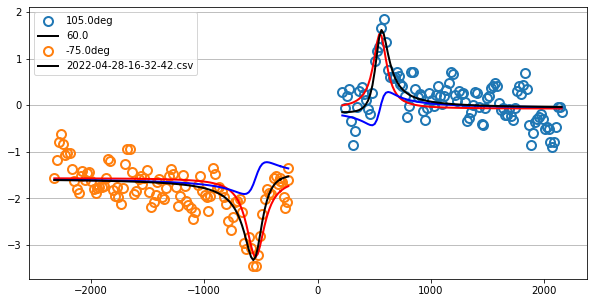

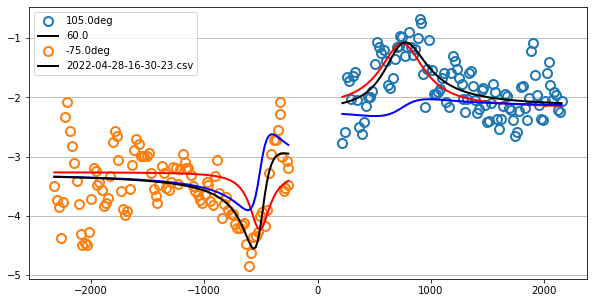

In [1216]:
pos = Hr

para_p = np.zeros((len(files), 6))
para_n = np.zeros((len(files), 6))
std_err_p = []
std_err_n = []
lowpts = 0
highpts = 0
curves_p = []
curves_n = []

plt.figure(figsize = (15,10))
for i in range(len(files)):
    import_files = pd.read_csv(files[i])
    result = import_files.values
    Datamax, Datamin = np.max(result[:,1]), np.min(result[:,1])
    #Hr = float(((result[result[:,1]==Datamax,0]+result[result[:,1]==Datamin,0])/2)[0])
    
    max_ind = int(np.where(result[:,1]==Datamax)[0][0])
    min_ind = int(np.where(result[:,1]==Datamin)[0][0])

    if max_ind > min_ind:
        p_ind, n_ind = min_ind, max_ind
    elif max_ind < min_ind:
        p_ind, n_ind = max_ind, min_ind
    
#    lowpts = 70
#    highpts = 70
#    if p_ind-highpts < 0 or n_ind+highpts>=len(result[:,0]):
#        highpts=p_ind-5   
#    if p_ind+lowpts > zero_ind or n_ind-lowpts<zero_ind:
#        lowpts=-p_ind+zero_ind+20
        
    
    results = pd.read_csv(files[i])
    length = len(results.values[:,0])
    #H_p = results.values[p_ind-highpts:p_ind+lowpts,0]-Hr
    #Vmix_p = results.values[p_ind-highpts:p_ind+lowpts,1]
    H_p0 = results.values[int(length*0.15):int(length*0.51),0]-Hr
    H_p = x2[int(length*0.15):int(length*0.51),1]*-1-125
    Vmix_p = results.values[int(length*0.15):int(length*0.51),1]
    
    #plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    try:
        para_L, cov_L = optimize.curve_fit(Lorentzian,H_p,Vmix_p, [0.0, 0.0, 80, 700, 280])
    except RuntimeError:
        print('RuntimeError (+)',fs[i],files[i].split('/')[-1].split('_')[-1])
    if para_L[2] < 0:
        para_L[1],para_L[2] = para_L[1]*-1,para_L[2]*-1
    plt.figure(figsize = (10,5))
    plt.grid(axis = 'y')
    plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9, label = str(fs[i]+45)+'deg')
    plt.plot(H_p, Lorentzian(H_p,para_L[0],0,para_L[2],para_L[3],para_L[4]), color = 'red', linewidth = 2)
    plt.plot(H_p, Lorentzian(H_p,0,para_L[1],para_L[2],para_L[3],para_L[4]), color = 'blue', linewidth = 2)
    plt.plot(H_p, Lorentzian(H_p,para_L[0],para_L[1],para_L[2],para_L[3],para_L[4]), label = fs[i],color = 'black', linewidth = 2)
    para_p[i,0] = fs[i]
    para_p[i,1:] = para_L
    std_err_p.append(np.sqrt(np.diag(cov_L))[2])
    
    #H_n = results.values[n_ind-lowpts:n_ind+highpts,0]-Hr
    #Vmix_n = results.values[n_ind-lowpts:n_ind+highpts,1]
    H_n0 = results.values[int(length*0.58):int(length*0.95),0]-Hr
    H_n = x2[int(length*0.58):int(length*0.95),1]*-1-125
    Vmix_n = results.values[int(length*0.58):int(length*0.95),1]
    #plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    try:
        para_L, cov_L = optimize.curve_fit(Lorentzian,H_n,Vmix_n, [0.0, 0.0, -80, -700, 280])
    except RuntimeError:
        print('RuntimeError (-)',fs[i],files[i].split('/')[-1].split('_')[-1])
    if para_L[2] < 0:
        para_L[1],para_L[2] = para_L[1]*-1,para_L[2]*-1
    plt.plot(H_n,Vmix_n,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9, label = str(fs[i]-135)+'deg')
    plt.plot(H_n, Lorentzian(H_n,para_L[0],0,para_L[2],para_L[3],para_L[4]), color = 'red', linewidth = 2)
    plt.plot(H_n, Lorentzian(H_n,0,para_L[1],para_L[2],para_L[3],para_L[4]), color = 'blue', linewidth = 2)
    plt.plot(H_n, Lorentzian(H_n,para_L[0],para_L[1],para_L[2],para_L[3],para_L[4]), label = files[i].split('/')[-1].split('_')[-1],color = 'black', linewidth = 2)
    para_n[i,0] = fs[i]
    para_n[i,1:] = para_L
    std_err_n.append(np.sqrt(np.diag(cov_L))[2])
    
    if i==0:
        curves_p.append(results.values[:zero_ind,0]-Hr)
        curves_n.append(results.values[zero_ind:,0]-Hr)
    
    curves_p.append(results.values[:zero_ind,1]-para_p[i,-1])
    curves_n.append(results.values[zero_ind:,1]-para_n[i,-1])
    

    plt.legend()

In [1217]:
para_n[:,2] = para_n[:,2]*-1
para_n[:,4] = para_n[:,4]*-1
para_p[:,0] += 45
para_n[:,0] += 225

t = ['fix', 'S', 'A', 'Delta', 'H0', 'V0', 'S/A']
para_pn = np.zeros((len(files)*2,7))
for i in range(len(files)):
    para_pn[2*i,:-1] = para_p[i,:]
    para_pn[2*i+1,:-1] = para_n[i,:]
    
para_pn[:,-1] = para_pn[:,1]/para_pn[:,2]
#print(para_pn)

tt = ['fix', 'S', 'S_err', 'A', 'A_err', 'Delta', 'Delta_err', 'H0', 'H0_err', 'V0','V0_err', 'S/A','S/A_err']
para_pn_avg = np.zeros((len(freq),13))
para_p_avg = np.zeros((len(freq),13))
para_n_avg = np.zeros((len(freq),13))
para_pn_avg[:,0] = freq
para_p_avg[:,0] = freq
para_n_avg[:,0] = freq
print('f',freq)
for i in range(6):
    para_slice = data_slicing(para_pn[:,i+1],np.array(file_count)*2)
    if i != 5:
        p_slice = data_slicing(para_p[:,i+1],file_count)
        n_slice = data_slicing(para_n[:,i+1],file_count)
    else:
        p_slice = data_slicing(para_p[:,1]/para_p[:,2],file_count)
        n_slice = data_slicing(para_n[:,1]/para_n[:,2],file_count)
        
    for k in range(len(file_count)):
        para_pn_avg[k,2*i+1] = np.mean(para_slice[k])
        para_pn_avg[k,2*i+2] = np.std(para_slice[k])
        para_p_avg[k,2*i+1] = np.mean(p_slice[k])
        para_p_avg[k,2*i+2] = np.std(p_slice[k])
        para_n_avg[k,2*i+1] = np.mean(n_slice[k])
        para_n_avg[k,2*i+2] = np.std(n_slice[k])

    print(tt[2*i+1], np.around(para_p_avg[:,2*i+1],2),'\n\t',np.around(para_n_avg[:,2*i+1],2))
    print(tt[2*i+2], np.around(para_p_avg[:,2*i+2],2),'\n\t',np.around(para_n_avg[:,2*i+2],2))


f [-15.0, 0.0, 15.0, 30.0, 45.0, 60.0]
S [3.06 5.49 3.84 3.35 1.41 0.73] 
	 [ 6.25  7.22  8.82  5.7   2.45 -1.27]
S_err [0.31 0.77 0.86 1.27 0.83 1.08] 
	 [0.37 0.97 0.34 0.93 0.58 0.27]
A [-15.13 -11.22 -18.56  -9.07  -2.5    0.85] 
	 [12.08  7.92 17.19  9.12  3.73 -1.2 ]
A_err [0.14 0.26 0.54 0.38 0.76 0.38] 
	 [0.04 1.59 0.56 0.65 0.22 0.36]
Delta [ 74.42  69.85  64.85  69.67  82.66 119.14] 
	 [75.09 81.34 62.58 59.74 56.74 95.89]
Delta_err [ 0.7   8.83  2.92  3.23 16.83 68.2 ] 
	 [ 0.6  14.35  2.12  3.03  5.11  6.85]
H0 [526.6  481.48 469.87 458.33 455.05 559.89] 
	 [503.33 485.01 453.12 448.89 451.57 287.52]
H0_err [  3.91   5.73   6.58   8.84  29.02 121.27] 
	 [  5.16   8.98   3.83   5.1    5.16 400.51]
V0 [ 2.18  3.1   5.9   2.33 -0.41 -0.97] 
	 [ 1.1   1.3   3.04 -0.83 -3.29 -2.05]
V0_err [0.25 0.57 0.46 0.13 0.38 0.85] 
	 [0.2  0.59 0.73 0.68 0.46 1.22]
S/A [-0.2  -0.49 -0.21 -0.37 -0.77  1.55] 
	 [0.52 0.96 0.51 0.63 0.66 1.24]
S/A_err [0.02 0.06 0.05 0.16 0.72 1.75] 
	 [0.03

No handles with labels found to put in legend.


S =  [-0.41569224 -2.09927909  6.41311874 -9.35723076] 
A =  [-10.34786958 -10.22850289  -0.88208077  -9.08864343]


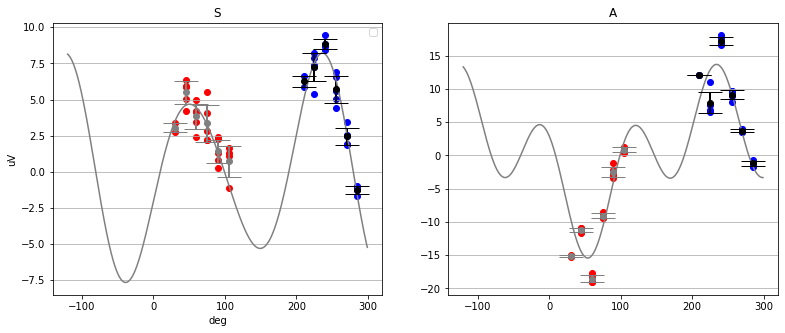

In [1218]:
#S & A
plt.figure(figsize = (13,5))
fs, freq=np.array(fs),np.array(freq)

n_shift = 225

fit_x = np.append(fs+45,fs+n_shift)
fit_S = np.append(para_p[:,1],para_n[:,1])
fit_A = np.append(para_p[:,2],para_n[:,2])
para_S,para_A = [30,1,1,4],[30,1,1,4]
x=np.arange(-120,300)
try:
    para_S, cov_S = optimize.curve_fit(Angdep,fit_x,fit_S,[30,1,1,4])
    para_A, cov_A = optimize.curve_fit(Angdep,fit_x,fit_A,[30,1,1,4])
    print('S = ',para_S,'\nA = ',para_A)
except RuntimeError:
    print('RuntimeError')
    
plt.subplot(121)
plt.title('S')

plt.plot(x,Angdep(x,para_S[0],para_S[1],para_S[2],para_S[3]),color='grey')
plt.scatter(fs+n_shift,para_n[:,1], color='b')
plt.scatter(fs+45,para_p[:,1], color='r')
plt.errorbar(freq+n_shift,para_n_avg[:,1], yerr=para_n_avg[:,2], fmt='o',ecolor='k',color='k',elinewidth=2,capsize=12)
plt.errorbar(freq+45,para_p_avg[:,1], yerr=para_p_avg[:,2], fmt='o',ecolor='grey',color='grey',elinewidth=2,capsize=12)

plt.ylabel('uV')
plt.xlabel('deg')
plt.grid(axis = 'y')
plt.legend()

#error bar by multiple measurements  
plt.subplot(122)
plt.title('A')
plt.plot(x,Angdep(x,para_A[0],para_A[1],para_A[2],para_A[3]),color='grey')
plt.errorbar(freq+n_shift,para_n_avg[:,3], yerr=para_n_avg[:,4], fmt='o',ecolor='k',color='k',elinewidth=2,capsize=12)
plt.errorbar(freq+45,para_p_avg[:,3], yerr=para_p_avg[:,4], fmt='o',ecolor='grey',color='grey',elinewidth=2,capsize=12)
plt.scatter(fs+n_shift,para_n[:,2], color='b')
plt.scatter(fs+45,para_p[:,2], color='r')
plt.grid(axis = 'y')

No handles with labels found to put in legend.


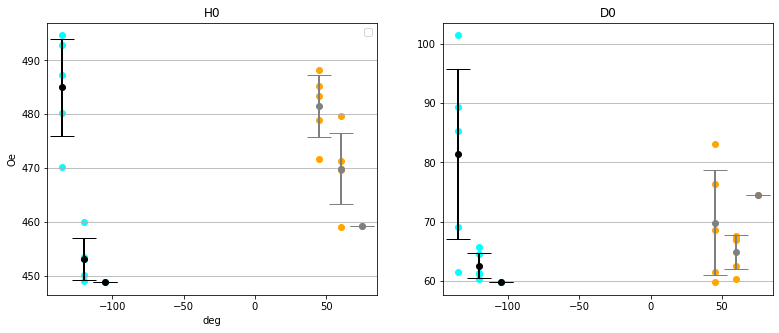

In [1196]:
#H0 & Linewidth
plt.figure(figsize = (13,5))

plt.subplot(121)
plt.title('H0')

plt.scatter(fs-135,para_n[:,4], color='cyan')
plt.scatter(fs+45,para_p[:,4], color='orange')
plt.errorbar(freq-135,para_n_avg[:,7], yerr=para_n_avg[:,8], fmt='o',ecolor='k',color='k',elinewidth=2,capsize=12)
plt.errorbar(freq+45,para_p_avg[:,7], yerr=para_p_avg[:,8], fmt='o',ecolor='grey',color='grey',elinewidth=2,capsize=12)

plt.ylabel('Oe')
plt.xlabel('deg')
plt.grid(axis = 'y')
plt.legend()

#error bar by multiple measurements  
plt.subplot(122)
plt.title('D0')
plt.errorbar(freq-135,para_n_avg[:,5], yerr=para_n_avg[:,6], fmt='o',ecolor='k',color='k',elinewidth=2,capsize=12)
plt.errorbar(freq+45,para_p_avg[:,5], yerr=para_p_avg[:,6], fmt='o',ecolor='grey',color='grey',elinewidth=2,capsize=12)
plt.scatter(fs-135,para_n[:,3], color='cyan')
plt.scatter(fs+45,para_p[:,3], color='orange')
plt.grid(axis = 'y')

In [57]:
K = data_slicing(para_n[:,4],file_count)
for i in range(len(freq)):
    print(freq[i]+45,np.around(K[i],2))

-90.0 [718.66 625.25 589.4  708.58 410.78]
-75.0 [632.46 617.34 634.66 626.66 618.23]
-60.0 [623.68 623.85 629.57 629.37 624.61]
-45.0 [607.19 611.68 606.58 615.17 604.51]
-30.0 [590.21 592.31 594.85 578.43 587.67]
-15.0 [581.8  570.35 556.31 595.65 575.4 ]
0.0 [ 582.46 -596.02 -139.61  759.19 1281.71]
15.0 [610.79 621.72 611.   593.71 604.18]
30.0 [653.81 627.61 633.79 634.86 622.45 642.62]
45.0 [642.76 632.8  632.89 631.55 629.2 ]
60.0 [579.25 609.73 592.58 569.22 596.03]
75.0 [567.18 549.51 479.8  535.84 511.06]


In [296]:
para_n_avg[:,0] -= 180
A = np.vstack((para_p_avg[:,0:5],para_n_avg[:,0:5]))
A[:,0] += 45

NAME='W262-0327-2'
directory = '/Users/didierjim/Documents/SCREAM/Analysis/fitted/'
np.savetxt(directory+NAME+'_angdep.csv',A,delimiter=',',header='deg,S,S_err,A,A_err')

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
45.0
60.0
75.0
90.0
105.0
120.0
135.0
150.0
165.0
180.0
195.0
(12, 165) (11, 165)
(165, 23) (136, 23)
Hext,45.0deg,60.0deg,75.0deg,90.0deg,105.0deg,120.0deg,135.0deg,150.0deg,165.0deg,180.0deg,195.0deg,45.0S+A,60.0S+A,75.0S+A,90.0S+A,105.0S+A,120.0S+A,135.0S+A,150.0S+A,165.0S+A,180.0S+A,195.0S+A,


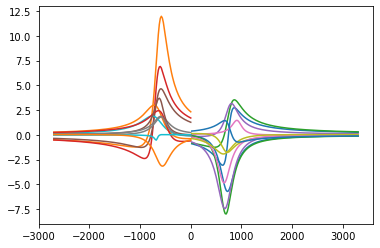

In [297]:
#Curves
pick_ind=[0]
k=0
for i in file_count[:-1]:
    k+=i
    pick_ind.append(k)
    
curves_p1,curves_n1,curves_p2,curves_n2 = [np.array(curves_p[0])],[np.array(curves_n[0])],[],[]
if len(curves_n[0]) == 0:
    print("zero-ind has been assigned a wrong value")
print(pick_ind)
for i in pick_ind:
    print(para_p[i,0])
    L_p = Lorentzian(np.array(curves_p[0]),para_p[i,1],para_p[i,2],para_p[i,3],para_p[i,4],0)
    L_n = Lorentzian(np.array(curves_n[0]),para_n[i,1],-para_n[i,2],para_n[i,3],-para_n[i,4],0)
    
    plt.plot(curves_p[0],L_p)
    plt.plot(curves_n[0],L_n)
    curves_p1.append(curves_p[i+1])
    curves_n1.append(curves_n[i+1])
    curves_p2.append(L_p)
    curves_n2.append(L_n)

print(np.shape(curves_p1),np.shape(curves_p2))
#print(np.array(curves_p[0]))
P=np.vstack((np.array(curves_p1),np.array(curves_p2))).transpose()
N=np.vstack((np.array(curves_n1),np.array(curves_n2))).transpose()
#N[:,0] = -1*N[:,0]
print(np.shape(P),np.shape(N))

header = 'Hext,'
header2 = 'Hext,'
for j in range(2):
    for i in freq:
        if j==0:
            header+=str(i+45)+'deg,'
            header2+=str(i-135)+'deg,'
        elif j==1:
            header+=str(i+45)+'S+A,'
            header2+=str(i-135)+'S+A,'
print(header)
np.savetxt(directory+NAME+'curP.csv',P,delimiter=',',header=header)
np.savetxt(directory+NAME+'curN.csv',N,delimiter=',',header=header2)
#6, 9, 1, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]

In [298]:
#raw fitting
K=np.vstack((para_p,para_n))
np.savetxt(directory+NAME+'angraw.csv',K,delimiter=',',header='f,S,A,D,H0,V0')
print(K[:,0])

[ 45.  45.  45.  45.  45.  60.  60.  60.  60.  60.  75.  75.  75.  75.
  75.  90.  90.  90.  90.  90. 105. 105. 105. 105. 105. 120. 120. 120.
 120. 120. 135. 135. 135. 135. 135. 150. 150. 150. 150. 150. 165. 165.
 165. 165. 165. 180. 180. 180. 180. 195. 195. 195. 195. 195. 225. 225.
 225. 225. 225. 240. 240. 240. 240. 240. 255. 255. 255. 255. 255. 270.
 270. 270. 270. 270. 285. 285. 285. 285. 285. 300. 300. 300. 300. 300.
 315. 315. 315. 315. 315. 330. 330. 330. 330. 330. 345. 345. 345. 345.
 345. 360. 360. 360. 360. 375. 375. 375. 375. 375.]
